# Treinamento dos modelos de preço do Airbnb

Este notebook documenta o fluxo final do projeto de previsão de faixas de preço para anúncios do Airbnb, desde a preparação do ambiente até a geração de explicações dos modelos. Use-o como guia durante apresentações ou como documentação para novos membros do time.

## Visão Geral do Pipeline

### 1. Preparação do Ambiente
- Atualiza o `pip` e instala as principais bibliotecas usadas nas etapas de modelagem (`pandas`, `numpy`, `scikit-learn`, `xgboost`) e de interpretação (`shap`, `lime`).
- Garante compatibilidade de versão para pacotes sensíveis (`shap`, `xgboost`, `jupyter`) para evitar surpresas entre máquinas.

### 2. Configuração e Preparação dos Dados
- Importa o dataset processado do repositório com `pd.read_csv`.
- Remove colunas redundantes e restringe `price` a valores positivos.
- Aplica log transform e clipping para reduzir o efeito de outliers.
- Cria atributos derivados como `bath_per_bedroom`, representando densidade de banheiros por quarto.
- Constrói a variável categórica `price_class` via `pd.qcut`, produz `X` e `y`, força o cast para numérico e trata ausências.
- Divide o conjunto em treino/teste estratificado e padroniza as features numéricas com `StandardScaler`.

### 3. Modelagem e Avaliação
- Converte as classes com `LabelEncoder` e treina três famílias de modelos:
  - **Regressão Logística**, como baseline linear.
  - **Random Forest Classifier** com busca aleatória (`RandomizedSearchCV`) para ajustar profundidade e divisão mínima.
  - **XGBClassifier** com busca aleatória para taxa de aprendizado, profundidade e regularização.
- Armazena as métricas de acurácia e o relatório de classificação de cada modelo, mantendo os resultados consolidados para comparação.
- Escolhe o melhor modelo pela maior acurácia obtida no conjunto de teste.

### 4. Métricas Detalhadas
- Calcula acurácia, precisão, recall e F1 ponderado do modelo escolhido.
- Exibe a matriz de confusão (`sns.heatmap`) e o relatório por classe para interpretar erros de cada faixa de preço.
- Converte as previsões para a escala original de preço quando necessário, facilitando a comunicação com o público de negócio.

### 5. Interpretação dos Resultados
- Para modelos baseados em árvore, usa `shap.TreeExplainer` para gerar `summary_plot` e barras de importância média, salvando os gráficos em `.png`.
- Complementa com explicações locais usando `lime.lime_tabular.LimeTabularExplainer`, exibindo as probabilidades previstas e o impacto de cada feature em uma amostra do teste.

### 6. Treinamento Final e Persistência
- Re-treina o melhor estimador com 100% dos dados após recodificar as classes.
- Salva o modelo final, o scaler e o codificador (`joblib.dump`) para reutilização em APIs, pipelines ou notebooks futuros.


## Preparação do ambiente

Execute as células a seguir apenas ao configurar um novo ambiente. Elas garantem que todas as dependências usadas na modelagem e na interpretação estejam atualizadas.

In [42]:
pip install -U pip setuptools wheel pandas numpy matplotlib seaborn scikit-learn xgboost shap lime jupyter ipywidgets tqdm


  Using cached xgboost-3.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.1-py3-none-win_amd64.whl (72.0 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6
Note: you may need to restart the kernel to use updated packages.


In [43]:
pip install --upgrade shap


Note: you may need to restart the kernel to use updated packages.


In [44]:
pip install xgboost==1.7.6


  Using cached xgboost-1.7.6-py3-none-win_amd64.whl.metadata (1.9 kB)
Using cached xgboost-1.7.6-py3-none-win_amd64.whl (70.9 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.1
    Uninstalling xgboost-3.1.1:
      Successfully uninstalled xgboost-3.1.1
Note: you may need to restart the kernel to use updated packages.


In [45]:
pip install --upgrade ipython jupyter


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip uninstall -y xgboost


In [58]:
pip install "xgboost>=2.0.0"

  Using cached xgboost-3.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.1-py3-none-win_amd64.whl (72.0 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6
Note: you may need to restart the kernel to use updated packages.


## 1. Configuração e preparação dos dados

- Carrega o dataset processado disponível no repositório.
- Remove colunas redundantes e garante que o alvo price tenha valores válidos.
- Aplica transformação logarítmica, clipping de outliers e cria atributos derivados úteis.
- Divide os dados em treino e teste e normaliza as features numéricas.

In [46]:
# ==========================================================
# 1. Configuração, Carregamento e Preparação dos Dados (CLASSIFICAÇÃO)
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import shap
import lime
import lime.lime_tabular

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

# ----------------------------------------------------------
# Carregar dados
file_path = 'https://raw.githubusercontent.com/RaphaelRAY/airbnb-rating-ml/refs/heads/main/data/processed/listings_Encode.csv'
df = pd.read_csv(file_path)

print(f"Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.")

# Limpeza e seleção
cols_to_drop = [
    'review_scores_rating', 
    'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms'
]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
df = df[df['price'] > 0]

# Log-transform do preço
df['price'] = np.log1p(df['price'])

# Clipping (remove extremos)
df['price'] = df['price'].clip(
    lower=df['price'].quantile(0.01),
    upper=df['price'].quantile(0.99)
)

# Features derivadas úteis
if 'accommodates' in df.columns and 'bathrooms' in df.columns and 'bedrooms' in df.columns:
    df['bath_per_bedroom'] = df['bathrooms'] / (df['bedrooms'] + 1)

# ----------------------------------------------------------
# Criar classes de preço (baixo / médio / alto)
# ----------------------------------------------------------
df['price_class'] = pd.qcut(df['price'], q=3, labels=['baixo', 'medio', 'luxo'])

X = df.drop(columns=['price', 'price_class'])
y = df['price_class']

X = X.apply(pd.to_numeric, errors='coerce').fillna(X.mean())

# Split (estratificado para manter proporções)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Treino: {X_train.shape[0]} | Teste: {X_test.shape[0]}")

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Dataset carregado com 41724 linhas e 40 colunas.
Treino: 33379 | Teste: 8345


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41724 entries, 0 to 41723
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   host_response_rate                     41724 non-null  float64 
 1   host_acceptance_rate                   41724 non-null  float64 
 2   host_listings_count                    41724 non-null  float64 
 3   host_total_listings_count              41724 non-null  float64 
 4   host_has_profile_pic                   41724 non-null  float64 
 5   host_identity_verified                 41724 non-null  float64 
 6   latitude                               41724 non-null  float64 
 7   longitude                              41724 non-null  float64 
 8   accommodates                           41724 non-null  int64   
 9   bathrooms                              41724 non-null  float64 
 10  bedrooms                               41724 non-null  flo

## 2. Modelagem e avaliação

Treinamos três famílias de modelos (Regressão Linear, Random Forest e XGBoost) com busca aleatória de hiperparâmetros quando aplicável. As métricas são calculadas na escala log transformada de price e armazenadas para comparação posterior.

In [48]:
# Converter classes para valores numéricos
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


In [59]:
# ==========================================================
# 2. Modelagem e Avaliação (CLASSIFICAÇÃO)
# ==========================================================

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

models = {}
results = []

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Modelo': model_name, 'Acurácia': acc})
    print(f"--- {model_name} ---\nAcurácia: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    return model

# ----------------------------------------------------------
# Regressão Logística (equivalente linear para classificação)
print("\nTreinando Regressão Logística...")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
models['LogisticRegression'] = evaluate_model(lr, X_test_scaled, y_test, 'Regressão Logística')

# ----------------------------------------------------------
# Random Forest Classifier
print("\nTreinando Random Forest Classifier...")
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist_rf, n_iter=5,
    cv=3, scoring='accuracy', n_jobs=-1, random_state=42
)
search_rf.fit(X_train_scaled, y_train)
best_rf = search_rf.best_estimator_
models['RandomForestClassifier'] = evaluate_model(best_rf, X_test_scaled, y_test, 'Random Forest Classifier')
print(f"Melhores hiperparâmetros RF: {search_rf.best_params_}")

# XGBoost Classifier
print("\nTreinando XGBoost Classifier...")

param_dist_xgb = {
    'n_estimators': [300, 500],
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [1, 2],
}

xgb = XGBClassifier(
    random_state=69,
    n_jobs=-1,
    eval_metric='mlogloss',   # métrica ok p/ multiclasse
    objective='multi:softprob',
    num_class=3               # já que você tem 3 classes (0,1,2)
)

search_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist_xgb,
    n_iter=5,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    error_score='raise',      # opcional
)

search_xgb.fit(X_train_scaled, y_train)
best_xgb = search_xgb.best_estimator_

models['XGBClassifier'] = evaluate_model(
    best_xgb, X_test_scaled, y_test, 'XGBoost Classifier'
)

print(f"Melhores hiperparâmetros XGB: {search_xgb.best_params_}")




Treinando Regressão Logística...
--- Regressão Logística ---
Acurácia: 0.5901
              precision    recall  f1-score   support

           0       0.61      0.68      0.65      2785
           1       0.69      0.64      0.67      2781
           2       0.46      0.45      0.46      2779

    accuracy                           0.59      8345
   macro avg       0.59      0.59      0.59      8345
weighted avg       0.59      0.59      0.59      8345


Treinando Random Forest Classifier...
--- Random Forest Classifier ---
Acurácia: 0.6689
              precision    recall  f1-score   support

           0       0.67      0.77      0.72      2785
           1       0.75      0.71      0.73      2781
           2       0.58      0.53      0.55      2779

    accuracy                           0.67      8345
   macro avg       0.67      0.67      0.67      8345
weighted avg       0.67      0.67      0.67      8345

Melhores hiperparâmetros RF: {'n_estimators': 200, 'min_samples_split'

In [67]:
print("X_train_scaled.shape:", X_train_scaled.shape)
print("n_features_in_ best_xgb:", best_xgb.n_features_in_)
print("X_test_scaled.shape:", X_test_scaled.shape)


X_train_scaled.shape: (33379, 35)
n_features_in_ best_xgb: 35
X_test_scaled.shape: (8345, 35)


Classe original	Valor codificado
baixo	0
medio	1
alto	2


## 3. Escolha do melhor modelo

Os resultados coletados são reunidos em um DataFrame para identificação do maior R². Em seguida, resgatamos a instância treinada correspondente para prosseguir com as análises.

In [60]:
# ==========================================================
# 3. Escolha do melhor modelo (CLASSIFICAÇÃO)
# ==========================================================

# Constrói dataframe de resultados
results_df = pd.DataFrame(results)

# Identifica o melhor modelo com base na acurácia
best_model_name = results_df.loc[results_df['Acurácia'].idxmax(), 'Modelo']

# Busca o modelo exato pelo nome
best_model = None
if 'Logística' in best_model_name:
    best_model = models['LogisticRegression']
elif 'Random Forest' in best_model_name:
    best_model = models['RandomForestClassifier']
elif 'XGBoost' in best_model_name:
    best_model = models['XGBClassifier']
else:
    raise ValueError("Nome do modelo não reconhecido.")

print(f"\nMelhor modelo: {best_model_name}")
print(results_df.sort_values('Acurácia', ascending=False).reset_index(drop=True))



Melhor modelo: XGBoost Classifier
                     Modelo  Acurácia
0        XGBoost Classifier  0.691672
1  Random Forest Classifier  0.668904
2       Regressão Logística  0.590054


## 4. Métricas em preço real

Revertemos a transformação logarítmica para apresentar RMSE, MAE e R² diretamente em reais, tornando a interpretação das métricas mais intuitiva para o público de negócio.


===== Métricas detalhadas =====
Acurácia : 0.6917
Precisão : 0.6907
Recall   : 0.6917
F1-Score : 0.6906

===== Relatório por classe =====
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      2785
           1       0.77      0.74      0.76      2781
           2       0.60      0.57      0.58      2779

    accuracy                           0.69      8345
   macro avg       0.69      0.69      0.69      8345
weighted avg       0.69      0.69      0.69      8345



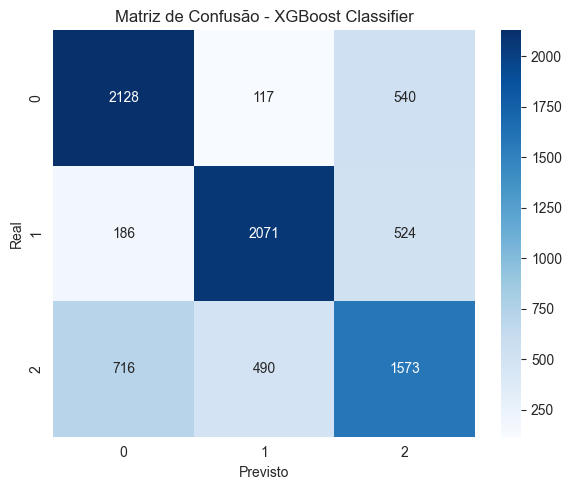

In [61]:
# ==========================================================
# 4. Métricas detalhadas do melhor modelo (CLASSIFICAÇÃO)
# ==========================================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Previsões
y_pred = best_model.predict(X_test_scaled)

# Métricas principais
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n===== Métricas detalhadas =====")
print(f"Acurácia : {acc:.4f}")
print(f"Precisão : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")

# Relatório completo
print("\n===== Relatório por classe =====")
print(classification_report(y_test, y_pred))

# Matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f"Matriz de Confusão - {best_model_name}")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


## 5. Interpretação com SHAP

Geramos gráficos do SHAP (summary plot e barras de importância média) para explicar como cada feature contribui para o preço previsto pelo melhor modelo. As figuras são salvas em disco para inclusão em relatórios.

In [64]:
print(X.shape)          # (n_linhas, n_features)
print(X.columns)
print(X_test_scaled.shape)


(41724, 35)
Index(['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'host_days_active', 'amenities_count',
       'host_response_time_a few days or more', 'host_response_time_unknown',
       'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'neighbourhood_cleansed_encoded',
       'property_type_encoded', 'bath_per_bedroom'],
      dtype='object')
(8345, 35)



Gerando SHAP Summary Plot (versão compatível - Classificação)...
Usando shap.TreeExplainer...
TreeExplainer falhou, caindo para KernelExplainer.
Erro: could not convert string to float: '[3.3377272E-1,3.3320352E-1,3.3302376E-1]'


  0%|          | 0/500 [00:00<?, ?it/s]

shape shap_values_mean: (500, 35, 3)
shape X_sample: (500, 35)


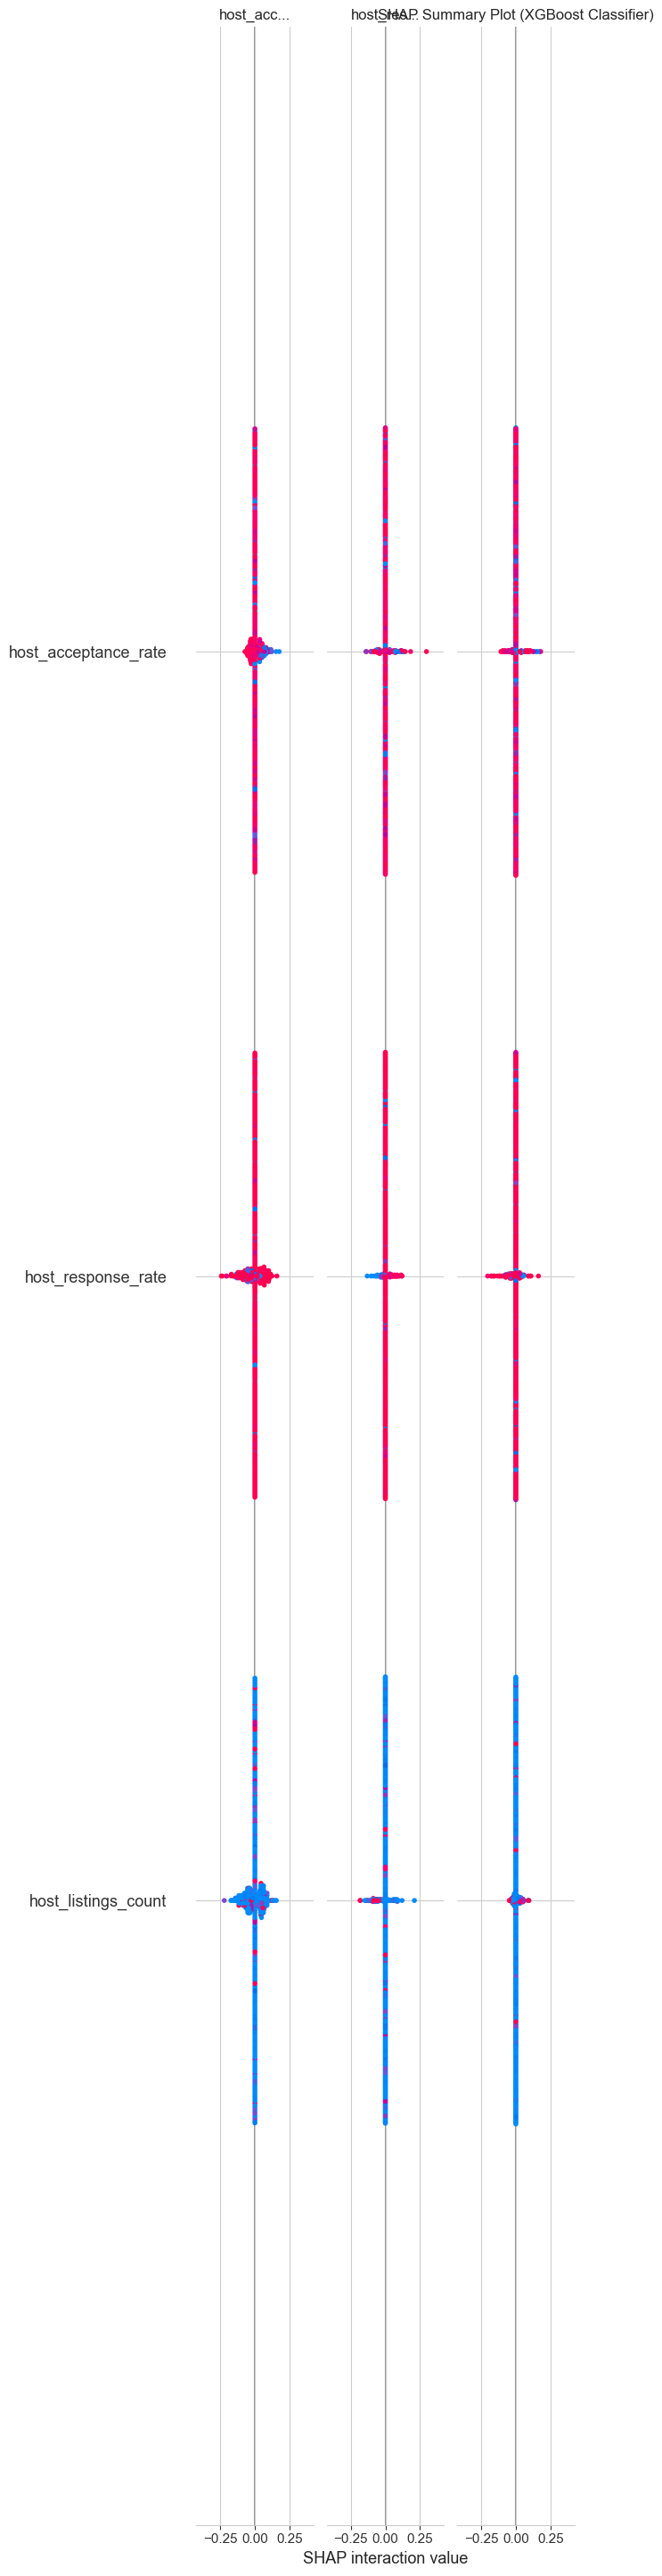

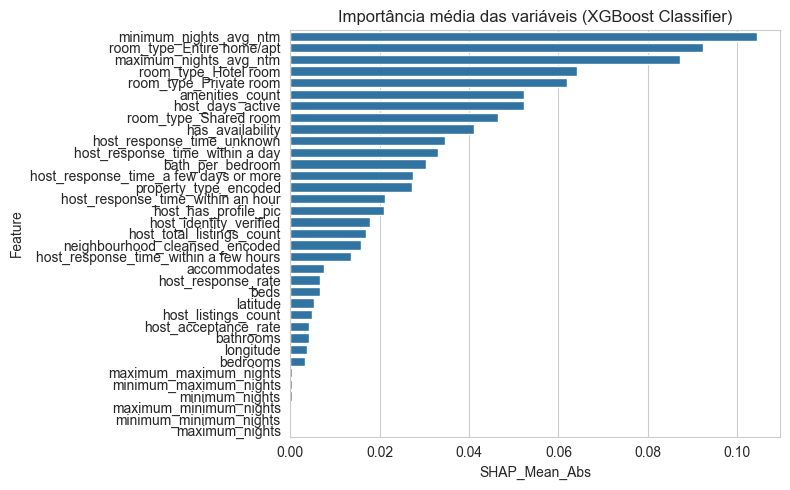

In [65]:
# ==========================================================
# 5. Interpretação com SHAP (versão robusta - Classificação)
# ==========================================================

if 'Forest' in best_model_name or 'XGB' in best_model_name:
    print("\nGerando SHAP Summary Plot (versão compatível - Classificação)...")

    n_sample = min(500, X_test_scaled.shape[0])
    X_sample = pd.DataFrame(
        X_test_scaled,
        columns=X.columns
    ).sample(n=n_sample, random_state=42)

    # ------------------------------------------------------
    # Tenta TreeExplainer, senão cai pro KernelExplainer
    # ------------------------------------------------------
    try:
        print("Usando shap.TreeExplainer...")
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_sample)
    except Exception as e:
        print("TreeExplainer falhou, caindo para KernelExplainer.\nErro:", e)
        background = X_sample.sample(
            n=min(100, len(X_sample)),
            random_state=42
        )
        explainer = shap.KernelExplainer(
            best_model.predict_proba,
            background
        )
        shap_values = explainer.shap_values(X_sample)

    # ------------------------------------------------------
    # Normalizar formato dos SHAPs para (n_amostras, n_features)
    # ------------------------------------------------------
    if isinstance(shap_values, list):
        # shap_values: lista [n_classes] de arrays (n_amostras, n_features)
        # empilha em (n_classes, n_amostras, n_features)
        sv = np.array(shap_values)                         # (C, N, F)
        # média sobre as classes -> (N, F)
        shap_values_mean = sv.mean(axis=0)
    else:
        # já está em (N, F)
        shap_values_mean = shap_values

    print("shape shap_values_mean:", shap_values_mean.shape)
    print("shape X_sample:", X_sample.shape)

    # ------------------------------------------------------
    # Summary plot com TODAS as features (ou até 35)
    # ------------------------------------------------------
    max_feats = min(35, X_sample.shape[1])
    shap.summary_plot(
        shap_values_mean,
        X_sample,
        show=False,
        max_display=max_feats
    )
    plt.title(f"SHAP Summary Plot ({best_model_name})")
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png')
    plt.show()

    # ------------------------------------------------------
    # Importância média absoluta por feature
    # ------------------------------------------------------
    shap_importance = np.abs(shap_values_mean).mean(axis=0)  # (F,)

    # Garante alinhamento com as colunas
    shap_importance = np.ravel(shap_importance)
    n_features = min(len(shap_importance), len(X.columns))

    feature_names = X.columns[:n_features]
    shap_importance = shap_importance[:n_features]

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Mean_Abs': shap_importance
    }).sort_values(by='SHAP_Mean_Abs', ascending=False).head(max_feats)

    plt.figure(figsize=(8, 5))
    sns.barplot(x='SHAP_Mean_Abs', y='Feature', data=importance_df)
    plt.title(f"Importância média das variáveis ({best_model_name})")
    plt.tight_layout()
    plt.savefig('shap_feature_importance.png')
    plt.show()


In [55]:
import lime
import lime.lime_tabular
import numpy as np

print("\nGerando explicação LIME para uma amostra...")

# Cria o explicador (modo classificação)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X.columns,
    class_names=le.classes_,  # ['baixo', 'medio', 'alto']
    mode='classification'
)

# Escolhe uma amostra do conjunto de teste
i = np.random.randint(0, X_test_scaled.shape[0])
sample = X_test_scaled[i]

# Gera explicação
exp = explainer_lime.explain_instance(
    data_row=sample,
    predict_fn=best_model.predict_proba
)

# Mostra resultados básicos
print(f"\nExplicando a amostra #{i} (classe real: {le.inverse_transform([y_test[i]])[0]})")
print("Probabilidades previstas:", dict(zip(le.classes_, best_model.predict_proba([sample])[0])))

print("\nImpacto das variáveis:")
for f, v in exp.as_list():
    print(f"{f}: {v:.3f}")



Gerando explicação LIME para uma amostra...

Explicando a amostra #7687 (classe real: luxo)
Probabilidades previstas: {'baixo': np.float64(0.024679474722360845), 'luxo': np.float64(0.8635212516795728), 'medio': np.float64(0.11179927359806635)}

Impacto das variáveis:
-0.50 < bathrooms <= 0.71: 0.098
bedrooms > 0.55: 0.094
host_response_time_unknown <= -0.48: -0.049
-0.52 < latitude <= -0.16: 0.040
-0.49 < longitude <= 0.54: 0.036
-0.16 < beds <= 0.40: 0.028
room_type_Hotel room <= -0.02: -0.026
0.04 < accommodates <= 0.50: 0.024
bath_per_bedroom <= -0.30: -0.023
room_type_Shared room <= -0.09: 0.018


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encoder para converter as classes em números
le = LabelEncoder()
y_full_encoded = le.fit_transform(y)

# Escalonar novamente
X_full_scaled = scaler.fit_transform(X)

# Recriar o modelo com os mesmos hiperparâmetros
final_model = best_model.__class__(**best_model.get_params())

# Treinar com 100% dos dados (agora com labels numéricos)
final_model.fit(X_full_scaled, y_full_encoded)

print("✅ Modelo final treinado com 100% dos dados.")



✅ Modelo final treinado com 100% dos dados.


In [ ]:
import joblib

joblib.dump(final_model, 'modelo_airbnb.pkl')
joblib.dump(scaler, 'scaler_airbnb.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("✅ Modelo, scaler e label encoder salvos com sucesso.")


✅ Modelo, scaler e label encoder salvos com sucesso.
